In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
df = pd.read_csv('SDSS_DR17.csv')
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [3]:
df['class'].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [4]:
df['class'].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

In [5]:
encoder = LabelEncoder()
df['class'] = encoder.fit_transform(df['class'])

In [6]:
df['class'].value_counts()

class
0    59445
2    21594
1    18961
Name: count, dtype: int64

In [7]:
X = df.drop(columns=['obj_ID', 'class']).values
y = df['class'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000, 16), (30000, 16), (70000,), (30000,))

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
traindatset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
testdatset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

trainloader = DataLoader(traindatset, batch_size=128, shuffle=True)
testloader = DataLoader(testdatset, batch_size=128)

In [12]:
# Hyperparameters
input_dim = X_train.shape[1]
output_dim = 3
lr = 0.0001
epochs = 100

#### Model

In [13]:
class ClassificationANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.hidden(x)


In [14]:
model = ClassificationANN(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#### Training Loop

In [15]:
train_loss = []
test_loss = []

for epoch in range(epochs):
    model.train()
    train_epoch_loss = 0
    for features, labels in trainloader:

        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()

    train_loss.append(train_epoch_loss/len(trainloader))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch : {epoch+1}/{epochs}, Loss = {loss:4f}")

    model.eval()
    test_epoch_loss = 0
    with torch.no_grad():
        for features, labels in testloader:
            y_pred = model(features)
            loss = criterion(y_pred, labels)

            test_epoch_loss += loss.item()

        test_loss.append(test_epoch_loss/len(testloader))


torch.save(model.state_dict(), "ClassificationANN.pth")

Epoch : 10/100, Loss = 0.156962
Epoch : 20/100, Loss = 0.346265
Epoch : 30/100, Loss = 0.152298
Epoch : 40/100, Loss = 0.123694
Epoch : 50/100, Loss = 0.156666
Epoch : 60/100, Loss = 0.441638
Epoch : 70/100, Loss = 0.170406
Epoch : 80/100, Loss = 0.110351
Epoch : 90/100, Loss = 0.195011
Epoch : 100/100, Loss = 0.052516


#### Results and Analysis

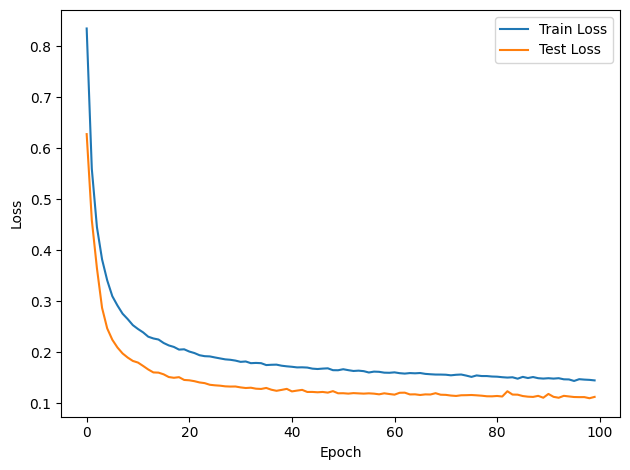

In [21]:
plt.plot(train_loss, label = 'Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig('Losses.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
correct = 0
total = 0

y_true = []
y_pred = []  
y_score = []  

model.eval()
with torch.no_grad():
    for features, labels in testloader:
        output = model(features)

        probs = torch.softmax(output, dim=1)  # softmax for ROC
        predicted = torch.argmax(probs, dim=1)  # argmax for accuracy

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())     
        y_score.extend(probs.cpu().numpy())        

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Accuracy = {accuracy:.4f}")


Accuracy = 96.5400


In [23]:
class_names = encoder.classes_
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     17845
         QSO       0.96      0.91      0.94      5700
        STAR       0.96      0.98      0.97      6455

    accuracy                           0.97     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.97      0.97      0.97     30000



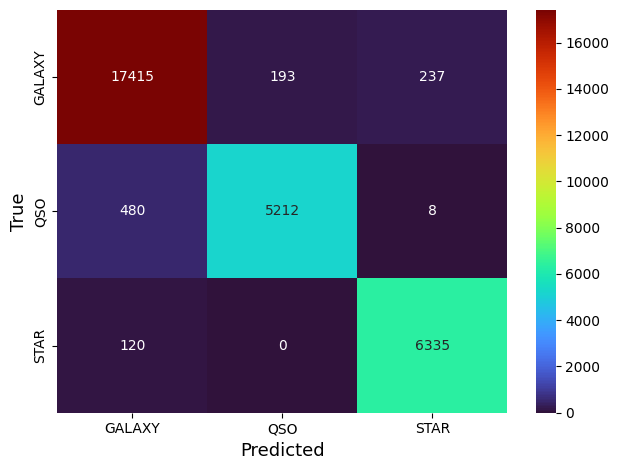

In [24]:
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap='turbo')
plt.xlabel("Predicted", fontsize=13)
plt.ylabel("True",fontsize=13)
plt.tight_layout()
plt.savefig('Confusion Matrix.png', dpi=300, bbox_inches='tight')
plt.show()

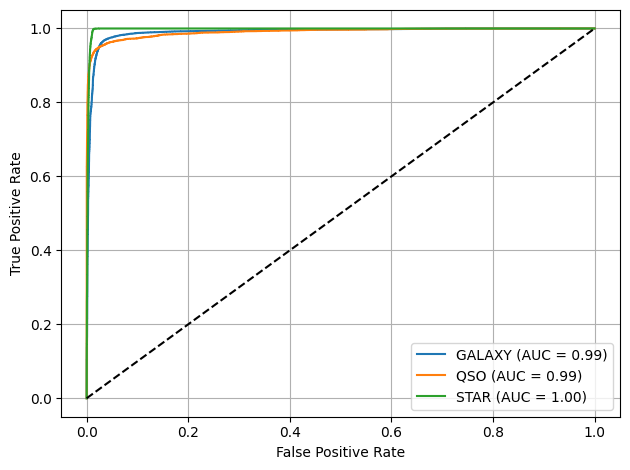

In [26]:
y_true = np.array(y_true)
y_score = np.array(y_score)

# One-hot encode y_true
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_score.shape[1]

# Compute ROC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.savefig('ROC Curve.png', dpi=300, bbox_inches='tight')
plt.show()
